## LIBRARIES

In [2]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io
import scipy
from scipy import signal


## LOADING THE DATA

In [4]:
""" Define schema of datasets
"""

DATABASE = {
    'Database 1': ['female_1',
                  'female_2',
                  'female_3',
                  'male_1',
                  'male_2'],
    'Database 2': ['male_day_1',
                  'male_day_2',
                  'male_day_3']
}

COLUMNS = ['cyl_ch1', 
            'cyl_ch2', 
            'hook_ch1', 
            'hook_ch2', 
            'tip_ch1', 
            'tip_ch2', 
            'palm_ch1', 
            'palm_ch2', 
            'spher_ch1', 
            'spher_ch2', 
            'lat_ch1', 
            'lat_ch2']

LABELS = [
    'Spherical',
    'Tip',
    'Palmar',
    'Lateral',
    'Cylindrical',
    'Hook'
]

COL_MAPPINGS = {
            'cyl_ch1': 'Cylindrical', 
            'cyl_ch2': 'Cylindrical', 
            'hook_ch1': 'Hook', 
            'hook_ch2': 'Hook', 
            'tip_ch1': 'Tip', 
            'tip_ch2': 'Tip', 
            'palm_ch1': 'Palmar', 
            'palm_ch2': 'Palmar', 
            'spher_ch1': 'Spherical', 
            'spher_ch2': 'Spherical', 
            'lat_ch1': 'Lateral', 
            'lat_ch2': 'Lateral'
}

In [13]:
""" Preprocess and standardize dataset into a single dataframe table
"""

DB_NAME = 'Database 1'
dfs = []
for fname in DATABASE[DB_NAME]: 
    tmp_data = scipy.io.loadmat(f'./data/{DB_NAME}/{fname}')
    tmp_data = {k:v for k,v in tmp_data.items() if k in COLUMNS}
    for c in COLUMNS:
        tmp_dfx = pd.DataFrame(tmp_data[c])
        tmp_dfx['identifier'] = fname
        tmp_dfx['label'] = COL_MAPPINGS[c]
        dfs.append(pd.DataFrame(tmp_dfx))

        
dataset_ = pd.concat(dfs)

#combine coupled readouts
new_dfs = []
for lab in LABELS:
    new_temp = dataset_[dataset_['label'] == lab].values
    new_temp_comb = pd.DataFrame(np.concatenate((new_temp[:150,:3000],new_temp[150:,:3002]),axis=1))
    new_dfs.append(new_temp_comb)

dataset = pd.concat(new_dfs)
dataset.rename(columns={6001:'label', 6000:'identifier'}, inplace=True)
dataset.head()

df_features = dataset.iloc[:,:6000].copy()
df_labels = dataset.iloc[:, 6001]

let's have a look at the datset :

In [6]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,5992,5993,5994,5995,5996,5997,5998,5999,identifier,label
0,0.505726,0.531228,0.505726,0.021195,0.046696,-0.080812,0.021195,0.021195,0.123201,0.199706,...,0.227693,0.049139,-0.30797,-0.103908,0.100154,0.15117,-0.614063,-0.358985,female_3,Spherical
1,0.454723,0.174205,-0.182818,-0.386831,0.709739,0.633234,-0.029808,-0.20832,0.0977,0.582231,...,-0.333478,0.100154,0.71234,0.610309,0.559294,-0.410001,0.253201,-0.052892,female_3,Spherical
2,1.245273,0.123201,-2.273952,-2.936995,-0.335828,1.50029,1.398283,2.163332,0.403719,-0.131815,...,0.253201,-0.486524,-0.231447,-0.30797,0.100154,0.865386,0.635817,0.15117,female_3,Spherical
3,-0.080812,-0.182818,0.0977,0.123201,0.276211,0.352716,0.25071,0.199706,0.0977,-0.080812,...,0.227693,-0.818125,-0.052892,0.431755,0.457263,0.304216,0.125662,0.304216,female_3,Spherical
4,0.480224,0.021195,0.429221,0.021195,-0.004307,-0.106313,0.199706,0.199706,0.301713,0.276211,...,-0.103908,-1.124218,0.278708,0.94191,0.686832,0.023631,-1.124218,-0.333478,female_3,Spherical


In [24]:
data=dataset.to_csv('data.csv',index=False)

## Preprocessing the Data

In [8]:
from utilitis import *

To process the raw data, there are a few techniques to help clean up the data. Firstly, since this is a signal taking the absolute value is a reasonable way to reduce the variability and nosie in the data. Furthermore, smoothing the curve is also an effective way of reducing noise. The butterworth low pass filter is commonly used for signal processsing but a more general method is exponential smoothing (in this case Holt-Winters). 

In [27]:
df_abs = abs_val_filter(df_features)
#df_holt = holt_smoothing(df_abs.to_numpy(), s_level = 0.03, s_slope = 0.02)
df_butter = butterworth_low_pass_filter(df_abs.to_numpy(), frequency=5000, lp_filter=25, order=5)

In [28]:
df_butter[0].shape

(6000,)

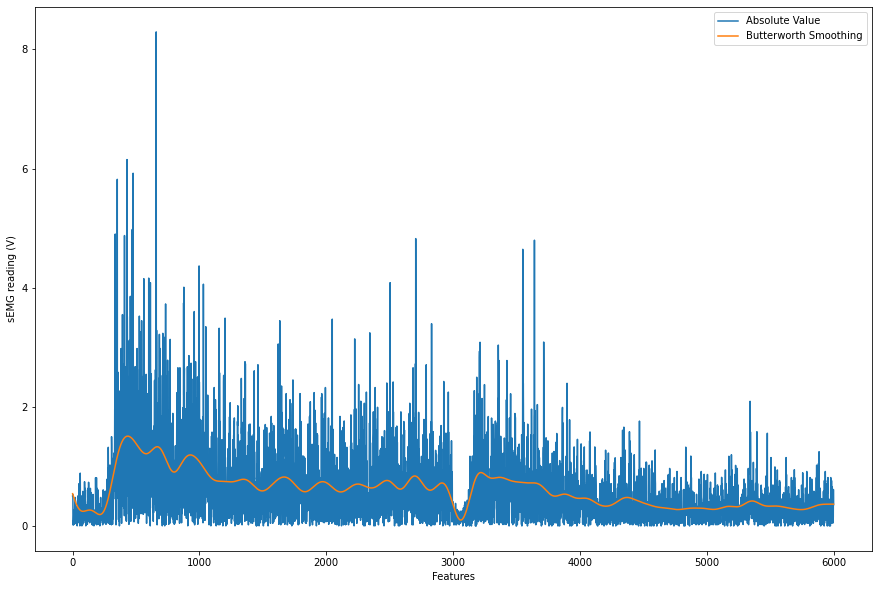

In [29]:
fig = plt.figure(figsize=(15,10))
plt.plot(df_abs.to_numpy()[0], label='Absolute Value')
#plt.plot(df_holt[0], label='Holt Smoothing')
plt.plot(df_butter[0], label='Butterworth Smoothing')
plt.legend(loc="upper right")
plt.xlabel("Features")
plt.ylabel("sEMG reading (V)")
plt.show()

At a glance we can see just how noisy the raw data is. The Holt-Winters smoothing does a good job of reducing the noise, whereas the Butterworth filter creates a very smooth curve that matches the Holt-Winters curve very well. We can perform the classification datasets on each of these models, but, 
in order to reduce the number of models that are being run, we will just move forward with the butterworth_low_pass_filter smoothed data. 

Now that the dataset is constructed the way we want it (6000 features + two columns one for the identifier and the other for the label), and preprocessed it using filters , We will now  save it in a csv format in a file called :   `dataset_processed.csv` 

In [12]:
df_butter=pd.DataFrame(df_butter)
df_butter.to_csv('dataset_processed.csv',index = False)